# Sleep Prediction - Unlocking the Secrets of Restful Nights
## In this problem we have to predict the sleep time. 

We have 8 years of historic health data taken from various devices including: Fitbit, Apple Watch and iPhone. <br>
This valuable data encompassed crucial metrics including step count, heart rate, exercise time, and energy burned.

#### In this notebook we are about to implement a Deep Neural Network using PyTorch
    
**So Let's get started with our eyes wide open Or..!!**

<img src="https://media.giphy.com/media/v1.Y2lkPTc5MGI3NjExNTQ3YWZhOTI3ODNkOGE1ZGFjNzRlYjQzMTlhNDc3NzA4ZWQwOGRmYSZlcD12MV9pbnRlcm5hbF9naWZzX2dpZklkJmN0PWc/vMbC8xqhIf9ny/giphy.gif" alt="Cat GIF" width="400" height="400">


In [1]:
# Check CUDA
!nvidia-smi

Fri May 26 09:45:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import Libs

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from tqdm.notebook import tqdm

import os
import re
import sys

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

import keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import layers

import torch
from torch import nn
from torch.utils.data import DataLoader, RandomSampler, TensorDataset

%matplotlib inline
plt.style.use('ggplot')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
HOME = '/kaggle/working/'
HOMEDATA = '/kaggle/input/kaggle-pog-series-s01e04/'

# Load Training Data

In [4]:
train = pd.read_csv(f'{HOMEDATA}FinalTrain.csv', parse_dates=['date'], index_col='date')
train.head()

,sleep_hours
date,
2015-02-19,6.400000
2015-02-20,7.583333
2015-02-21,6.350000
2015-02-22,6.500000
2015-02-23,8.916667


In [6]:
train.shape

(2354, 1)

# Include XML files

In [9]:
# Useful files and their aggregating methods
useful_files = {'StepCount.csv': 'sum',
                'HeartRate.csv': 'max',
                'DistanceWalkingRunning.csv': None, #--special treatment
                'BasalEnergyBurned.csv': 'sum',
                #'FlightsClimbed.csv',         #-- not seem fit
                'ActiveEnergyBurned.csv': 'sum',
                'Workout.csv': 'sum',
                'BodyMass.csv': 'max'}

In [10]:
def xml_data (data):
    temp = data.copy()
    for file in useful_files.keys():
        # Load file
        date_columns = ['startDate']
        if(file == 'Workout.csv'):
            data = pd.read_csv(f'{HOMEXML}{file}',usecols = ['startDate','duration'])
            data.rename(columns = {'duration':'value'}, inplace=True)
        else: 
            data = pd.read_csv(f'{HOMEXML}{file}',usecols = ['startDate','value'])
        data = data.sort_values('startDate').reset_index(drop=True)
        
        # Parse & Format the date
        for col in date_columns:
            data[col] = pd.to_datetime(data[col]).dt.tz_convert(None) #remove the UTC component, -0400
            data[col] = pd.to_datetime(data[col].apply(lambda x:x.strftime('%Y-%m-%d')))
    
        # Pre-process data 
        if file != 'DistanceWalkingRunning.csv':
            data = data.groupby('startDate').aggregate({'value': useful_files[file]})
        else:
            # Computation method for DistanceWalkingRunning
            dates = data['startDate'].unique()
            data_dict = {}
            for i, date in enumerate(dates):
                temp_dist = data[data['startDate'] == date]
                if max(temp_dist['value'].values) > 1:
                    data_dict[i] = (date, max(temp_dist['value'].values))
                else:
                    data_dict[i] = (date, sum(temp_dist['value'].values))
            data = pd.DataFrame(data_dict).T
            data.columns = ['startDate', 'value']
            data['value'] = data['value'].astype(float)
            data['startDate'] = pd.to_datetime(data['startDate'])
            data.set_index('startDate', inplace=True)
        
        # Merge with df
        trail = pd.merge(temp, data, how='inner', left_index = True, right_index = True)
        temp[file.split('.')[0]] = trail['value']
    return temp

### Impute Nan values of XML file

In [12]:
def xml_impute (data):
    temp = data.copy()
    print('Pre-Imputation\n', temp.isna().sum())
    temp.loc[((~pd.isnull(temp['Workout'])) & (pd.isnull(temp['HeartRate']))), 'HeartRate'] = \
            temp.loc[~pd.isnull(temp['Workout']), 'HeartRate'].mean()
    temp.loc[pd.isnull(temp['HeartRate']), 'HeartRate'] = 110
    temp['BasalEnergyBurned'] = temp['BasalEnergyBurned'].fillna(method='bfill')
    temp['BodyMass'] = temp['BodyMass'].fillna(method='ffill')
    temp.loc[pd.isnull(temp['Workout']), 'Workout'] = 0
    
    dates_na = temp[pd.isnull(temp['ActiveEnergyBurned'])].index
    # ActiveEnergyBurned - previous 7 days average
    for date in dates_na:
        impute_val = temp[((temp.index >= date - pd.DateOffset(days=7)) & \
                                    (temp.index < date))]['ActiveEnergyBurned']
        temp.loc[(temp.index == date), 'ActiveEnergyBurned'] = impute_val.mean()
    print('Post-Imputation\n', temp.isna().sum())
    return temp

# Feature Engineering

In [17]:
def createDateFeatures(data):
    temp = data.copy()
    temp['day'] = temp.index.day
    temp['month'] = temp.index.month
    temp['year'] = temp.index.year
    temp['weekofyear'] = temp.index.isocalendar().week.astype('int')
    temp['weekday'] = temp.index.weekday
    temp['dayofyear'] = temp.index.day_of_year
    
    temp['date_offset'] = (temp.index.month * 100 + temp.index.day - 320) % 1300
    temp['season'] = pd.cut(temp['date_offset'], 
                            bins=[0, 300, 602, 900, 1300],
                            labels=['spring', 'summer', 'fall', 'winter'])
    temp.drop('date_offset', axis=1, inplace=True)
    
    temp2 = pd.get_dummies(temp['season'])
    temp.drop('season', axis=1, inplace=True)
    temp = temp.merge(temp2, how='left', left_index=True, right_index=True)
    
    return temp

In [19]:
'''
    Our forecasting horizon is >1 years, 
    hence for lag of days, we'll compute iteratively from previous predictions.
'''
# Lag Features
def createLagFeatures(data):
    temp = data.copy()
    n=3 # Num of Lags
    # Day lag (3 days)
    for i in range(1, n+1):
        temp[f'day_lag_{i}'] = temp['sleep_hours'].shift(i)
        temp[f'day_lag_{i}'] = temp[f'day_lag_{i}'].bfill()
    # Year lag (1 year)
    temp[f'year_lag_{1}'] = temp['sleep_hours'].shift(364)
    temp[f'year_lag_{1}'] = temp[f'year_lag_{1}'].bfill()
    return temp

def random_noise(data):
    return np.random.normal(scale=1.5, size=(len(data)))
# Roll mean Features
def createRollMeanFeatures(data):
    windows = [3,7,14,28]
    temp = data.copy()
    for window in windows:
        temp['roll_mean_' + str(window)] = \
            temp['sleep_hours'].shift(1).rolling(window=window, win_type="triang").mean() \
                + random_noise(temp)
        temp['roll_mean_' + str(window)] = temp['roll_mean_' + str(window)].bfill()
    return temp

# Exponential Weighted Moving Average
def createEWMFeatures(data):
    alphas = [0.95,0.8]
    lags = [3,7,14,28]
    temp = data.copy()
    for alpha in alphas:
        for lag in lags:
            temp['ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                temp['sleep_hours'].shift(lag).ewm(alpha=alpha).mean()
            temp['ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                temp['ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)].bfill()
    return temp

In [21]:
import holidays

def get_holidays(df):
    years_list = np.arange(train_new.index.year.min(), train_new.index.year.max()+1)

    holiday_US = holidays.CountryHoliday('US', years = years_list)

    df['holiday_name'] = df.index.map(holiday_US)
    df['is_holiday'] = np.where(df['holiday_name'].notnull(), 1, 0)
    df['holiday_name'] = df['holiday_name'].fillna('Not Holiday')
    
    return df.drop(columns = ['holiday_name'])

# Split Feature and Target

In [26]:
X = train.drop('sleep_hours', axis=1)
y = train['sleep_hours']

In [27]:
X.columns

Index(['day', 'month', 'year', 'weekofyear', 'weekday', 'dayofyear', 'spring',
       'summer', 'fall', 'winter', 'day_lag_1', 'day_lag_2', 'day_lag_3',
       'year_lag_1', 'roll_mean_3', 'roll_mean_7', 'roll_mean_14',
       'roll_mean_28', 'ewm_alpha_095_lag_3', 'ewm_alpha_095_lag_7',
       'ewm_alpha_095_lag_14', 'ewm_alpha_095_lag_28', 'ewm_alpha_08_lag_3',
       'ewm_alpha_08_lag_7', 'ewm_alpha_08_lag_14', 'ewm_alpha_08_lag_28',
       'is_holiday', 'StepCount', 'HeartRate', 'DistanceWalkingRunning',
       'BasalEnergyBurned', 'ActiveEnergyBurned', 'Workout', 'BodyMass'],
      dtype='object')

# Train and Validation

In [28]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1883, 34), (471, 34), (1883,), (471,))

# Neural Network - PyTorch Implementation

In [ ]:
# tensorboard logs
from datetime import datetime
from keras.callbacks import TensorBoard, ReduceLROnPlateau
log_dir=f"{HOME}logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")

# metric='rmse'
metric='mean_absolute_error'

# callbaks 
tensorboard_callback = TensorBoard(log_dir=log_dir,
                                   histogram_freq=0,
                                   write_graph=False,
                                   update_freq='epoch')

# reduce learning Rate
reducelr = ReduceLROnPlateau(monitor=metric,
                             factor=np.sqrt(.01),
                             patience=2, #patcience
                             verbose=1,
                             mode='auto',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.00001)

### converting to tensor

In [51]:
X_train_pt = torch.tensor(X_train.values, dtype=torch.float32)
X_val_pt = torch.tensor(X_val.values, dtype=torch.float32)
y_train_pt = torch.tensor(y_train.values, dtype=torch.float32)
y_val_pt = torch.tensor(y_val.values, dtype=torch.float32)
X_train_pt.shape, X_val_pt.shape, y_train_pt.shape, y_val_pt.shape

(torch.Size([1883, 34]),
 torch.Size([471, 34]),
 torch.Size([1883]),
 torch.Size([471]))

### Checking for Cuda

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Running on:", device)

Running on: cuda


In [53]:
X_train_pt = X_train_pt.to(device)
X_val_pt = X_val_pt.to(device)
y_train_pt = y_train_pt.to(device)
y_val_pt = y_val_pt.to(device)

Running on: cuda


### Model

In [63]:
batch_size = 8

# Create a DataLoader for the training set
train_dataset = TensorDataset(X_train_pt, y_train_pt)
val_dataset = TensorDataset(X_val_pt, y_val_pt)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) # (len(X_train_pt)/batch_size, batch_size, n_features) == (236, 8, 34)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Estimate Loss on Validation set
@torch.no_grad()
def estimate_val():
    model.eval() # Switch to Evaluation mode
    val_loss = 0
    for x, y in val_loader:
        outputs = model(x).view(-1)
        loss = criterion(outputs, y)
        val_loss += loss.item()
    val_loss /= len(val_loader)
    model.train() # Switch to Training mode
    return val_loss
    
class MyModel(nn.Module):
    n1 = 64
    n2 = 32
    n3 = 16
    n4 = 1
    
    def __init__(self):
        super(MyModel, self).__init__()
        self.fc1 = nn.Linear(X_train_pt.shape[1], self.n1)
        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(self.n1, self.n2)
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(self.n2, self.n3)
        nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(self.n3, self.n4)

    def forward (self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        logits = self.fc4(x)
            
        return logits
    
# Build Model
model = MyModel().to(device)
criterion = nn.MSELoss()

# Add Logs for TensorBoard
log_dir=f"{HOME}torchlogs/"
writer = SummaryWriter(log_dir)
writer.add_graph(model, X_train_pt) # writer.add_graph(model, torch.randn(1, X_train_pt.shape[1]).to(device))
writer.close()

# create a PyTorch optimizer (Adam w/ Weight Decay)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.05)

# Gradient Descent
epochs = 50
early_stop = 10

# Define early stopping parameters
patience = 10
delta = 0.001
best_loss = float('inf')
best_model = None
counter = 0

for epoch in range(epochs):
    
    print(f"Epoch {epoch+1}/{epochs}")
                
    train_loss = 0.0
    for xb, yb in tqdm(train_loader, total=len(train_loader)):
        
        # sample a batch of data
        xb, yb = xb.to(device), yb.to(device)
        
        # forward
        y_pred = model(xb)
        y_pred = y_pred.view(-1)
        loss = criterion(yb, y_pred)
        
        # backward
        loss.backward()
        train_loss += loss.item()
        
        # update weights
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        
    train_loss /= len(train_loader)
    train_rmse = np.sqrt(train_loss)
    
    # Evaluate the model on the validation set
    val_loss = estimate_val()
    val_rmse = np.sqrt(val_loss)
    
    # Check if validation loss has improved
    if val_loss < best_loss - delta:
        best_loss = val_loss
        best_model = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Validation loss did not improve for {} epochs. Stopping training.".format(patience))
            break
    
    print(f'loss: {train_loss} - rmse: {train_rmse} - val_loss: {val_loss} - val_rmse: {val_rmse}')
    
# Load the best model
if best_model is not None:
    model.load_state_dict(best_model)

Epoch 1/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 678405.5527863796 - rmse: 823.6537821113793 - val_loss: 2.68696867409399 - val_rmse: 1.6391975701830424
Epoch 2/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 100.74263257596452 - rmse: 10.037062945701024 - val_loss: 2.648570072852959 - val_rmse: 1.6274428017146898
Epoch 3/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 309.15311367531956 - rmse: 17.582750458199637 - val_loss: 2.62138035741903 - val_rmse: 1.6190677433075584
Epoch 4/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 5.53801288493609 - rmse: 2.353298299182679 - val_loss: 2.5253967632681635 - val_rmse: 1.5891496981933966
Epoch 5/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 3.120753952507245 - rmse: 1.7665655811509646 - val_loss: 2.414947125871303 - val_rmse: 1.5540100147268365
Epoch 6/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 3.365327956817918 - rmse: 1.8344830216761119 - val_loss: 2.279780412124375 - val_rmse: 1.5098941724916932
Epoch 7/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 2.301390961570255 - rmse: 1.517033605946241 - val_loss: 2.132841795177783 - val_rmse: 1.4604252104020197
Epoch 8/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 2.283684529995514 - rmse: 1.51118646433705 - val_loss: 1.976128760030714 - val_rmse: 1.4057484696881992
Epoch 9/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 1.8989920136282 - rmse: 1.3780391916154635 - val_loss: 1.8123495740405584 - val_rmse: 1.3462353338256126
Epoch 10/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 1.7342479496689167 - rmse: 1.3169084818881367 - val_loss: 1.6448356034392018 - val_rmse: 1.2825114437848895
Epoch 11/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 1.8136856343786596 - rmse: 1.3467314633506784 - val_loss: 1.479434538695772 - val_rmse: 1.2163200806924845
Epoch 12/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 1.3940296258966802 - rmse: 1.1806903175247438 - val_loss: 1.3154106200751612 - val_rmse: 1.1469135190044457
Epoch 13/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 1.2319225661330304 - rmse: 1.1099200719569993 - val_loss: 1.1572507882522325 - val_rmse: 1.0757559148116418
Epoch 14/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 1.0764569804324942 - rmse: 1.037524448113149 - val_loss: 1.0072903410863068 - val_rmse: 1.0036385510164039
Epoch 15/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.9355159376637411 - rmse: 0.9672207285122363 - val_loss: 0.8665337087744374 - val_rmse: 0.9308779236690692
Epoch 16/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.7991954472105381 - rmse: 0.8939773191812744 - val_loss: 0.7378148840645612 - val_rmse: 0.8589615148914189
Epoch 17/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.6773584449695329 - rmse: 0.8230178886084633 - val_loss: 0.621840816938271 - val_rmse: 0.7885688409633436
Epoch 18/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.5677827375672632 - rmse: 0.7535135948125045 - val_loss: 0.5185569949069265 - val_rmse: 0.7201090159878062
Epoch 19/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.4794080254258746 - rmse: 0.6923929703758369 - val_loss: 0.4334702011892351 - val_rmse: 0.6583845389961972
Epoch 20/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.39215026379136714 - rmse: 0.6262190222209536 - val_loss: 0.35455416016659497 - val_rmse: 0.5954445063703208
Epoch 21/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.3194253911280026 - rmse: 0.565177309459609 - val_loss: 0.28915375294321677 - val_rmse: 0.5377301860070873
Epoch 22/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.2528640839066041 - rmse: 0.5028559275842377 - val_loss: 0.2448620659820104 - val_rmse: 0.49483539281463124
Epoch 23/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.16367725593874516 - rmse: 0.40457045855913054 - val_loss: 0.10162043836662325 - val_rmse: 0.3187796078274507
Epoch 24/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.14103203172148285 - rmse: 0.3755423168186015 - val_loss: 0.10434946575659816 - val_rmse: 0.323031679184253
Epoch 25/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.14275795437584995 - rmse: 0.3778332361979951 - val_loss: 0.06771127885933649 - val_rmse: 0.2602139098114021
Epoch 26/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.12946632172186243 - rmse: 0.35981428782340263 - val_loss: 0.07810638826024735 - val_rmse: 0.279475201512133
Epoch 27/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.12882154532787154 - rmse: 0.3589171844978609 - val_loss: 0.08339414770825435 - val_rmse: 0.2887804489716268
Epoch 28/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.11418106664224702 - rmse: 0.33790689049240624 - val_loss: 0.06628343361919209 - val_rmse: 0.2574556925360014
Epoch 29/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.09781374119348445 - rmse: 0.31275188439637647 - val_loss: 0.057215076097745 - val_rmse: 0.23919673095120886
Epoch 30/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.0849342752697925 - rmse: 0.29143485596234453 - val_loss: 0.052411935339539736 - val_rmse: 0.22893653124728638
Epoch 31/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.07033322171023967 - rmse: 0.2652041132981155 - val_loss: 0.044970387182498385 - val_rmse: 0.21206222478908965
Epoch 32/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.060986369613447555 - rmse: 0.24695418525193608 - val_loss: 0.03474164305854652 - val_rmse: 0.18639110241249854
Epoch 33/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.05342048658768378 - rmse: 0.23112872298285167 - val_loss: 0.031058384610687273 - val_rmse: 0.1762338917764891
Epoch 34/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.045141570475268164 - rmse: 0.21246545713425552 - val_loss: 0.026728673080392812 - val_rmse: 0.1634890610419939
Epoch 35/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.041592499269843416 - rmse: 0.20394239203717165 - val_loss: 0.023037669643507164 - val_rmse: 0.15178165120826417
Epoch 36/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.0335343891174643 - rmse: 0.18312397199019112 - val_loss: 0.02349815727606163 - val_rmse: 0.15329108674695222
Epoch 37/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.03205230772905683 - rmse: 0.17903158304907218 - val_loss: 0.024218678048227804 - val_rmse: 0.15562351380247075
Epoch 38/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.027846016380462354 - rmse: 0.1668712569032257 - val_loss: 0.018207389198369898 - val_rmse: 0.13493475904439856
Epoch 39/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.0251645056177641 - rmse: 0.15863324247383995 - val_loss: 0.017558510967735516 - val_rmse: 0.1325085316790414
Epoch 40/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.02256958793761935 - rmse: 0.15023178071772747 - val_loss: 0.018069694710548145 - val_rmse: 0.13442356456569712
Epoch 41/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.020496363723966276 - rmse: 0.14316551164287533 - val_loss: 0.015993923619705235 - val_rmse: 0.12646708512377927
Epoch 42/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.018793452568589 - rmse: 0.13708921390316964 - val_loss: 0.01552728894245574 - val_rmse: 0.12460854281491193
Epoch 43/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.017641133876908098 - rmse: 0.13281993026992636 - val_loss: 0.015167609851617934 - val_rmse: 0.12315685060774303
Epoch 44/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.016331084259051703 - rmse: 0.12779313071934542 - val_loss: 0.016989484808202518 - val_rmse: 0.13034371794682903
Epoch 45/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.015510944061087823 - rmse: 0.12454294063128517 - val_loss: 0.0168546731820551 - val_rmse: 0.12982554903429103
Epoch 46/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.014807186240401372 - rmse: 0.12168478228768531 - val_loss: 0.014913926650848935 - val_rmse: 0.12212258861835895
Epoch 47/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.014678528778041886 - rmse: 0.12115497834609144 - val_loss: 0.012937533416611663 - val_rmse: 0.11374327855575318
Epoch 48/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.013953004745663918 - rmse: 0.11812283752798998 - val_loss: 0.012274158739690053 - val_rmse: 0.11078880241111938
Epoch 49/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.013708852576308932 - rmse: 0.11708480933199204 - val_loss: 0.012763656304865065 - val_rmse: 0.11297635285698095
Epoch 50/50


  0%|          | 0/236 [00:00<?, ?it/s]

loss: 0.013355087500235256 - rmse: 0.11556421375250756 - val_loss: 0.012112351615865857 - val_rmse: 0.11005612938798937


In [ ]:
# Tensorboard
!cd {log_dir}
!tensorboard dev upload --logdir ./

In [64]:
print("Total Number of Parameters:", sum(p.numel() for p in model.parameters()))

Total Number of Parameters: 4865


In [77]:
with torch.no_grad():
    model.eval() # Switch to Evaluation mode
    y_pred = model(X_val_pt)
    y_pred = y_pred.view(-1)
    mse = criterion(y_val_pt, y_pred).cpu().numpy()
    rmse = np.sqrt(mse)
    mape = np.round(mean_absolute_percentage_error(y_val_pt.cpu().numpy(), y_pred.cpu().numpy()) * 100, 2)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("MAPE: {} %".format(mape))
    model.train() # Switch to Training mode

MSE: 0.012126778
RMSE: 0.11012165
MAPE: 4.74 %


# Predict on Test Set

In [35]:
test.drop('sleep_hours', axis=1, inplace=True)
test.head(10)

""
date
2022-01-01
2022-01-02
2022-01-03
2022-01-04
2022-01-05
2022-01-06
2022-01-07
2022-01-08
2022-01-19


In [36]:
test_xml = xml_data(test)
test_xml.head()

,StepCount,HeartRate,DistanceWalkingRunning,BasalEnergyBurned,ActiveEnergyBurned,Workout,BodyMass
date,,,,,,,
2022-01-01,20201,169.000,4.22901,2042.550,1772.419,80.672081,189.6
2022-01-02,25672,167.903,8.66981,2003.146,2990.995,164.242422,192.8
2022-01-03,20034,175.177,5.06094,2072.489,1971.896,98.093096,193.4
2022-01-04,15050,173.000,4.08979,2001.038,1562.286,76.400812,191.0
2022-01-05,16803,173.909,7.23904,1968.489,2292.182,140.844011,NaN


In [37]:
test_impute = xml_impute(test_xml)

Pre-Imputation
 StepCount                   0
HeartRate                   1
DistanceWalkingRunning      0
BasalEnergyBurned           1
ActiveEnergyBurned          1
Workout                   132
BodyMass                  316
dtype: int64
Post-Imputation
 StepCount                 0
HeartRate                 0
DistanceWalkingRunning    0
BasalEnergyBurned         0
ActiveEnergyBurned        0
Workout                   0
BodyMass                  0
dtype: int64


In [38]:
train_test = pd.concat((train_out, test), axis=0)
train_test

,sleep_hours
date,
2015-02-19,1.856298
2015-02-20,2.025953
2015-02-21,1.848455
2015-02-22,1.871802
2015-02-23,2.187922
...,...
2023-03-12,NaN
2023-03-13,NaN
2023-03-14,NaN


In [39]:
train_test = createDateFeatures(train_test)
train_test = createLagFeatures(train_test)
train_test = createRollMeanFeatures(train_test)
train_test = createEWMFeatures(train_test)
train_test = get_holidays(train_test)
train_test

,sleep_hours,day,month,year,weekofyear,weekday,dayofyear,spring,summer,fall,winter,day_lag_1,day_lag_2,day_lag_3,year_lag_1,roll_mean_3,roll_mean_7,roll_mean_14,roll_mean_28,ewm_alpha_095_lag_3,ewm_alpha_095_lag_7,ewm_alpha_095_lag_14,ewm_alpha_095_lag_28,ewm_alpha_08_lag_3,ewm_alpha_08_lag_7,ewm_alpha_08_lag_14,ewm_alpha_08_lag_28,is_holiday
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-02-19,1.856298,19,2,2015,8,3,50,0,0,0,1,1.856298,1.856298,1.856298,1.856298,-0.012079,3.325597,2.656051,2.666612,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,0
2015-02-20,2.025953,20,2,2015,8,4,51,0,0,0,1,1.856298,1.856298,1.856298,1.856298,-0.012079,3.325597,2.656051,2.666612,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,0
2015-02-21,1.848455,21,2,2015,8,5,52,0,0,0,1,2.025953,1.856298,1.856298,1.856298,-0.012079,3.325597,2.656051,2.666612,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,0
2015-02-22,1.871802,22,2,2015,8,6,53,0,0,0,1,1.848455,2.025953,1.856298,1.856298,-0.012079,3.325597,2.656051,2.666612,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,1.856298,0
2015-02-23,2.187922,23,2,2015,9,0,54,0,0,0,1,1.871802,1.848455,2.025953,1.856298,4.104539,3.325597,2.656051,2.666612,2.017874,1.856298,1.856298,1.856298,1.997677,1.856298,1.856298,1.856298,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-12,NaN,12,3,2023,10,6,71,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.770029,1.770029,1.770029,1.770029,1.756805,1.756805,1.756805,1.756805,0
2023-03-13,NaN,13,3,2023,11,0,72,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.770029,1.770029,1.770029,1.770029,1.756805,1.756805,1.756805,1.756805,0
2023-03-14,NaN,14,3,2023,11,1,73,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.770029,1.770029,1.770029,1.770029,1.756805,1.756805,1.756805,1.756805,0


In [40]:
# Remember actual test data start from >2021 (i.e., from 2022), 
# but here we are considering 1 year of training data to compute lag features iteratively with prediction
test_new = train_test[train_test.index.year>2019]

In [41]:
test_merge = test_new.merge(test_impute, how='left', left_index=True, right_index=True)
test_merge

,sleep_hours,day,month,year,weekofyear,weekday,dayofyear,spring,summer,fall,winter,day_lag_1,day_lag_2,day_lag_3,year_lag_1,roll_mean_3,roll_mean_7,roll_mean_14,roll_mean_28,ewm_alpha_095_lag_3,ewm_alpha_095_lag_7,ewm_alpha_095_lag_14,ewm_alpha_095_lag_28,ewm_alpha_08_lag_3,ewm_alpha_08_lag_7,ewm_alpha_08_lag_14,ewm_alpha_08_lag_28,is_holiday,StepCount,HeartRate,DistanceWalkingRunning,BasalEnergyBurned,ActiveEnergyBurned,Workout,BodyMass
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-01,1.848080,1,1,2020,1,2,1,0,0,0,1,2.089804,1.704748,1.824549,1.887070,2.484595,2.157827,0.676702,-0.320160,1.827996,1.828060,1.807234,1.811844,1.838589,1.828364,1.820884,1.827806,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02,1.752094,2,1,2020,1,3,2,0,0,0,1,1.848080,2.089804,1.704748,1.743386,1.981706,1.383927,2.888755,1.658626,1.710910,1.829819,1.913764,1.907000,1.731516,1.829602,1.899673,1.895168,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,1.943526,3,1,2020,1,4,3,0,0,0,1,1.752094,1.848080,2.089804,2.039053,1.235353,0.678437,3.845081,2.785090,2.070860,1.919527,1.900324,1.902352,2.018147,1.905319,1.899628,1.900720,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-04,2.008214,4,1,2020,1,5,4,0,0,0,1,1.943526,1.752094,1.848080,2.032525,2.156095,0.022728,1.088418,0.740770,1.859219,1.893478,1.987825,1.865818,1.882093,1.894750,1.973870,1.871260,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-05,1.840550,5,1,2020,1,6,5,0,0,0,1,2.008214,1.943526,1.752094,1.887430,1.511052,2.873878,1.996431,3.663316,1.757450,1.827996,2.005067,1.912036,1.778094,1.838589,1.999553,1.905827,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-12,NaN,12,3,2023,10,6,71,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.770029,1.770029,1.770029,1.770029,1.756805,1.756805,1.756805,1.756805,0,6865.0,125.0,3.238917,2117.631,440.980,0.000000,201.0
2023-03-13,NaN,13,3,2023,11,0,72,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.770029,1.770029,1.770029,1.770029,1.756805,1.756805,1.756805,1.756805,0,13752.0,183.0,4.218030,2196.882,1678.721,82.307355,201.8
2023-03-14,NaN,14,3,2023,11,1,73,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.770029,1.770029,1.770029,1.770029,1.756805,1.756805,1.756805,1.756805,0,21737.0,181.0,5.933210,2189.984,2289.884,112.872589,201.8


In [42]:
test_merge.columns

Index(['sleep_hours', 'day', 'month', 'year', 'weekofyear', 'weekday',
       'dayofyear', 'spring', 'summer', 'fall', 'winter', 'day_lag_1',
       'day_lag_2', 'day_lag_3', 'year_lag_1', 'roll_mean_3', 'roll_mean_7',
       'roll_mean_14', 'roll_mean_28', 'ewm_alpha_095_lag_3',
       'ewm_alpha_095_lag_7', 'ewm_alpha_095_lag_14', 'ewm_alpha_095_lag_28',
       'ewm_alpha_08_lag_3', 'ewm_alpha_08_lag_7', 'ewm_alpha_08_lag_14',
       'ewm_alpha_08_lag_28', 'is_holiday', 'StepCount', 'HeartRate',
       'DistanceWalkingRunning', 'BasalEnergyBurned', 'ActiveEnergyBurned',
       'Workout', 'BodyMass'],
      dtype='object')

In [43]:
train_part_len = len(test_merge[test_merge.index.year<2022])
train_part_len

714

In [44]:
test_merge.shape

(1133, 35)

## Forcast

In [88]:
test_iter_target = test_merge.copy()
with torch.no_grad():
    model.eval() # Switch to Evaluation mode
    for i in tqdm(range(len(test))):
        data_val = test_iter_target.iloc[train_part_len+i,1:].to_numpy()
        data_val = torch.tensor(data_val, dtype=torch.float32)
        data_val = data_val.to(device)
        pred_val = model(data_val)
        pred_val = pred_val.view(-1)
        
        # update target iteratively with prediction
        test_iter_target.iloc[train_part_len+i,0] = pred_val.item()

        # update roll_mean iteratively with prediction
        test_iter_target = createLagFeatures(test_iter_target)
        test_iter_target = createRollMeanFeatures(test_iter_target)
        test_iter_target = createEWMFeatures(test_iter_target)
    model.train() # Switch to Training mode

  0%|          | 0/419 [00:00<?, ?it/s]

In [89]:
test_final = test_iter_target[test_iter_target.index.year>2021]

### Inverse log transformation

In [90]:
test_y = np.exp(test_final['sleep_hours'])

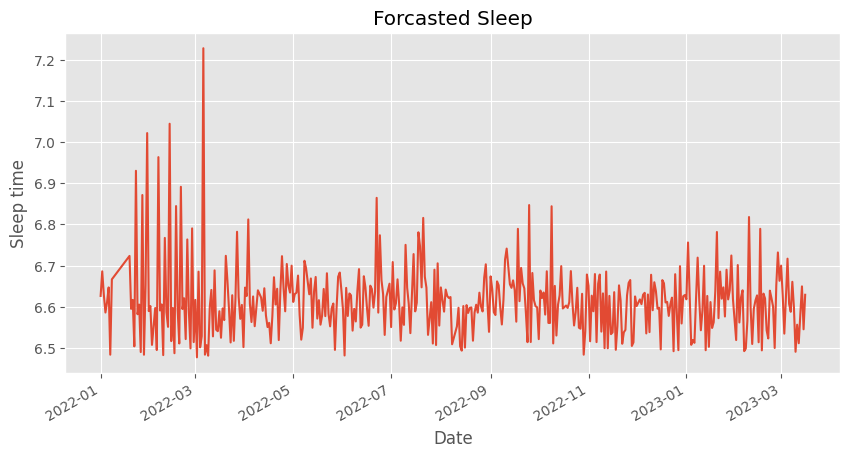

In [95]:
plt.figure(figsize=(10,5))
test_y.plot()
plt.title('Forcasted Sleep')
plt.ylabel('Sleep time')
plt.xlabel('Date')
plt.show()

# Conclusion

We have successfully implented deep neural network model using PyTorch and achieving superior performace.

### Neural Network:
Drawing upon the powerful capabilities of PyTorch, I constructed a sophisticated deep neural network model. By meticulously training the model on our meticulously curated dataset, I achieved remarkable results. The neural network surpassed expectations, attaining a strikingly low root mean square error (RMSE) of just 0.11. This achievement underscores the model's ability to capture intricate patterns in sleep data, empowering us to make highly accurate predictions.

- MSE : 0.01212 <br>
- RMSE : 0.11012 <br>
- MAPE : 4.74 % <br>

#### <font color='Brown'> In this model we are on an average 7 minutes off of the ground truth, which is pretty good! </font>

# END